# Season Plotting

__*python=3.6*__

> Author: [tilseb](tilseb@dtu.dk)
>
> Created: 2018-05-23
>
> Modified: 2019-12-07

## Description

The following script plots time series data from the main Balmorel Input Exel file (Data.xlsm), including solar power production (spp), variable electricity demand (ved), variable heat demand (vhd) and variable wind generation (vwg) for the year 2016. Considered countries are Denmark (DK), Germany (DE), Norway (NO) and Sweden (SE).

The user can decide, which seasons (weeks) and termns (hours) to plot and highlight. By default all 52 seasons per year and all 168 terms per season are plotted and every 24th term is highlighted to indicate the length of one day.

Each commodity is plotted for all countries and vice versa. The respective output directories are created, if not already existing.

## Content
- Import required packages
- Plot settings
- Read input files
- Format data frames
- Make directories
- Plot per commodity
- Plot per country

## Import Required Packages

In [83]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Plot Settings

In [84]:
# Set plotting specifications
#% matplotlib inline
plt.rcParams.update({'font.size': 21})
plt.rcParams['xtick.major.pad']='12'
plt.rc('legend', fontsize=16)
y_limit = 1.1
lw = 3

## Read Input Files

In [85]:
# Read the solar power production from Data.xlsm
spp = pd.read_excel('input/Data.xlsm',
                    sheet_name='43', header=11, skipfooter=8793, index_col=0)

In [86]:
# Read the solar heat production from Data.xlsm
shp = pd.read_excel('input/Data.xlsm',
                    sheet_name='43', usecols='A:B', header=8801, skipfooter=3, index_col=0)

In [87]:
# Read the solar power production from Data.xlsm
spp_old = pd.read_excel('input/Data_old.xlsm',
                        sheet_name='43', header=11, skipfooter=8793, index_col=0)

In [88]:
# Read the variation of wind generation from Data.xlsm
vwg = pd.read_excel('input/Data.xlsm',
                    sheet_name='53', usecols='A:Y', header=13, skipfooter=21, index_col=0)

In [89]:
# Read the old variation of wind generation from Data_old.xlsm
vwg_old = pd.read_excel('input/Data_old.xlsm',
                        sheet_name='53', usecols='A:Y', header=13, skipfooter=10, index_col=0)

In [90]:
# Read the opsd variation of wind generation from Data_wind_opsd.csv
# Source: https://data.open-power-system-data.org/time_series/
vwg_opsd = pd.read_csv('input/Data_wind_opsd.csv', encoding='utf8', index_col=0, parse_dates=True)

# and the installed capacities
wcap_opsd = pd.read_csv('input/Data_wind_cap_opsd.csv', encoding='utf8')
wcap_opsd.index = vwg.index

## Format Data Frames

In [91]:
# Make a list of all considered ountries
#ccc = ['DK', 'DE', 'NO', 'SE']
ccc = ['DE']

### Solar Power Production

In [92]:
# Make columns for seasons and terms
spp['season'] = spp.index.str.split('.').str[0]
spp['term'] = spp.index.str.split('.').str[1]

In [93]:
# Divide each number of each countries columns by it's annual maximum 
for c in ccc:
    for i in spp[spp.columns[spp.columns.str.contains(c)==True]].columns:
        spp[i] /= spp[i].max()

In [94]:
# Make columns for seasons and terms
spp_old['season'] = spp_old.index.str.split('.').str[0]
spp_old['term'] = spp_old.index.str.split('.').str[1]

In [95]:
# Divide each number of each countries columns by it's annual maximum 
for c in ccc[:2]:
    for i in spp_old[spp_old.columns[spp_old.columns.str.contains(c)==True]].columns:
        spp_old[i] /= spp_old[i].max()

In [96]:
# Make columns with country average
spp_old['DK'] = spp_old[spp_old.columns[spp_old.columns.str.contains('DK')==True]].sum(axis=1)
spp_old['DE'] = spp_old[spp_old.columns[spp_old.columns.str.contains('DE')==True]].sum(axis=1)

In [97]:
# Divide each number by each countries annual maximum
for c in ccc[:2]:
    spp_old[c] /= spp_old[c].max()

### Solar HeatProduction

In [98]:
# Make columns for seasons and terms
shp['season'] = shp.index.str.split('.').str[0]
shp['term'] = shp.index.str.split('.').str[1]

In [99]:
# Divide each number of each countries columns by it's annual maximum 
shp.DK2_Large /= shp.DK2_Large.max()

### Variation of Wind Generation

In [100]:
# Make columns for seasons and terms
vwg['season'] = vwg.index.str.split('.').str[0]
vwg['term'] = vwg.index.str.split('.').str[1]

In [101]:
# Divide each row of each countries columns by its hourly percentage and annual maximum
# Values greater than 1 are reduced to 1
for c in ccc:
    for i in vwg[vwg.columns[vwg.columns.str.contains(c)==True]].columns:
        if 'Offshore' in i:
            vwg[i] = vwg[i] / wcap_opsd['DE_wind_offshore_capacity_annual_relative'] / vwg[i].max()
            vwg[i] = np.where(vwg[i] > 1, 1, vwg[i])
        else:
            vwg[i] = vwg[i] / wcap_opsd['DE_wind_capacity_annual_relative'] / vwg[i].max()
            vwg[i] = np.where(vwg[i] > 1, 1, vwg[i])

In [102]:
# Shift the DE4-N profile 5 terms back and fill the last fife in a forward manner
vwg['adjust'] = vwg['DE4-N_A'].shift(-5).ffill()

# Calculate the difference between DE4-N and DE4-W_Offshore
diff = vwg['DE4-N_A'] - vwg['DE4-W_Offshore_A']

# Make an index for all differences greater than zero
idx = diff[diff>0].index

# Subtract the mean of the positive differences from the shifted DE4-N profile, where it occours
for i in idx:
    vwg.loc[i, 'DE4-W_Offshore_A'] = vwg.loc[i, 'adjust'] - diff[diff>0].mean()

# Convert all negative numerical entries to zero
num = vwg._get_numeric_data()
num[num < 0] = 0

# DE4-N_Offshore is the same as DE4-W_Offshore
vwg['DE4-N_Offshore_A'] = vwg['DE4-W_Offshore_A']

# DE4-E_Offshore is the same as DE4-E_Offshore
vwg['DE4-E_Offshore_A'] = vwg['DE4-W_A']

In [125]:
# Round and write the resulting profiles to a csv file
output = vwg[['DE4-N_Offshore_A','DE4-W_Offshore_A']].round(3)
output.to_csv('output/data/DE4-Offshore_A.csv', encoding='utf8')

In [104]:
# Make columns for seasons and terms
vwg_old['season'] = vwg_old.index.str.split('.').str[0]
vwg_old['term'] = vwg_old.index.str.split('.').str[1]

In [105]:
# Divide each number of each countries columns by it's annual maximum 
for c in ccc:
    for i in vwg_old[vwg_old.columns[vwg_old.columns.str.contains(c)==True]].columns:
        vwg_old[i] /= vwg_old[i].max()

In [106]:
# Make columns with country sums
for c in ccc:
    vwg_old[c] = vwg_old[vwg_old.columns[vwg_old.columns.str.contains(c)==True]].sum(axis=1)

In [107]:
# Divide each number by each countries annual maximum
for c in ccc:
    vwg_old[c] /= vwg_old[c].max()

## Select Seasons

In [108]:
# Make a list of all seasons
sss = list(spp.season.unique())

In [109]:
# Seasons to investigate
# season_names = ['S01', 'S07', 'S20', 'S24', 'S28', 'S38', 'S42', 'S43']

In [110]:
# Make a list of every nth element of sss (1 <= nth <= 52)
nth = 4
s = sss[0::nth]

# Or select seasons by names
# s = season_names

## Select Terms

In [111]:
# Make a list of all Terms per season
ttt = list(spp.term.unique())

In [112]:
# Terms to investigate
# term_names = ['T005', 'T019', 'T033', 'T047', 'T061', 'T075', 'T089', 'T103', 'T117', 'T131', 'T145', 'T159']

In [113]:
# Make a list of every nth element of ttt (1 <= nth <= 168)
nth = 1
t = ttt[0::nth]

# Or select terms by name
# t = term_names

## Make Directories

In [114]:
# Make output folder
dirs = {'output/figs', 'output/data'}
for d in dirs:
    if not os.path.isdir(d):
        os.makedirs(d)

In [115]:
# Make spp folder
if not os.path.isdir('output/figs/pv_production'):
    os.makedirs('output/figs/pv_production')

In [116]:
# Make vwg folder
if not os.path.isdir('output/figs/wind_generation'):
    os.makedirs('output/figs/wind_generation')

## Plotting

In [117]:
# Make data frames to plot
spp_plot = spp[(spp.season.isin(s)) & (spp.term.isin(t))]
shp_plot = shp[(shp.season.isin(s)) & (shp.term.isin(t))]
vwg_plot = vwg[(vwg.season.isin(s)) & (vwg.term.isin(t))]

In [118]:
# Set indices to terms
spp_plot.set_index('term', inplace=True)
shp_plot.set_index('term', inplace=True)
vwg_plot.set_index('term', inplace=True)

In [119]:
# Make data frames to plot
spp_old_plot = spp_old[(spp_old.season.isin(s)) & (spp_old.term.isin(t))]
vwg_old_plot = vwg_old[(vwg_old.season.isin(s)) & (vwg_old.term.isin(t))]

In [120]:
# Set indices to terms
spp_old_plot.set_index('term', inplace=True)
vwg_old_plot.set_index('term', inplace=True)

In [121]:
# Create vertical bars per step
steps = 24
t_selected = spp_plot.index.unique()[0::steps]
t_marker = np.arange(0, len(t), steps)

# Or mark selected terms
# t_selected = term_names
# t_marker = np.arange(0, len(t), steps)

In [122]:
vwg_plot.to_csv('output/data/Data_new.csv', encoding='utf8')

### Plot per Commodity 

#### Solar Power Production

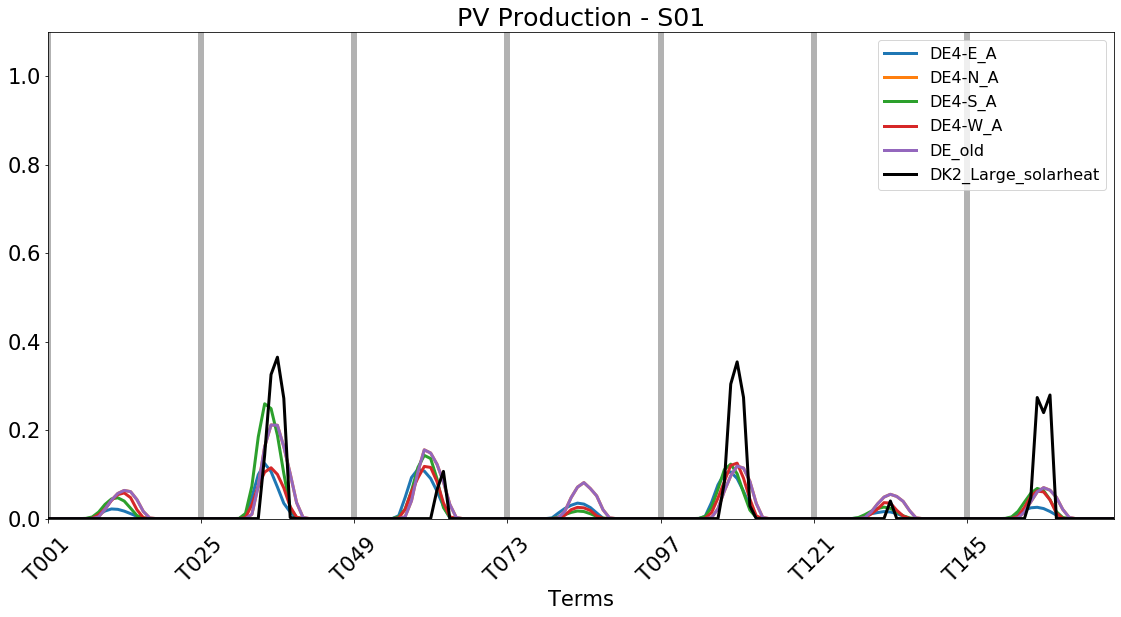

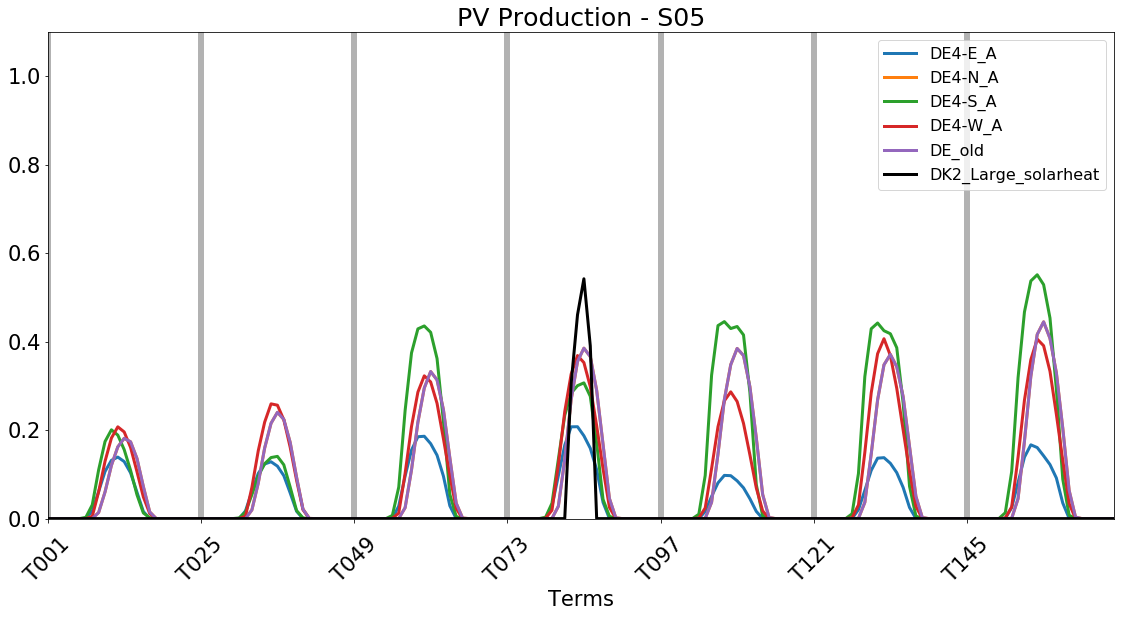

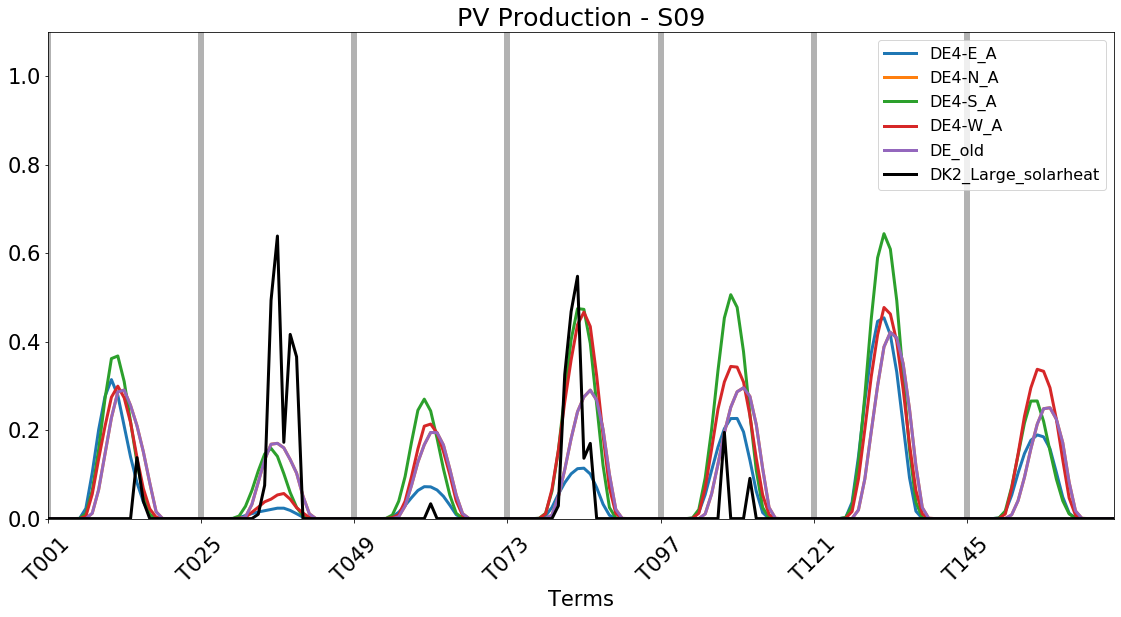

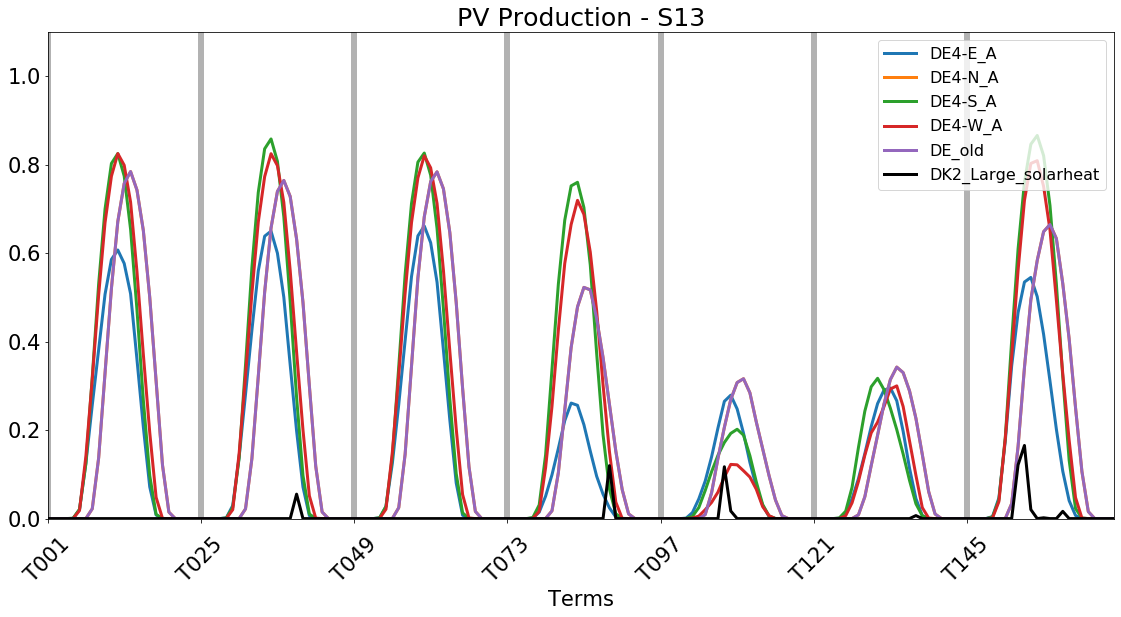

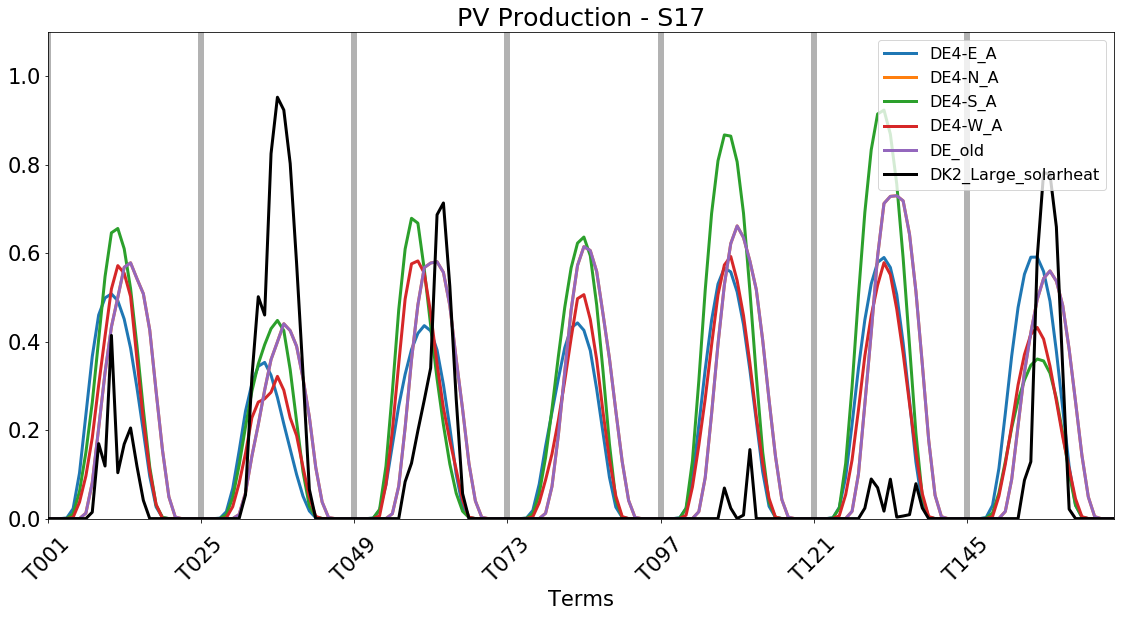

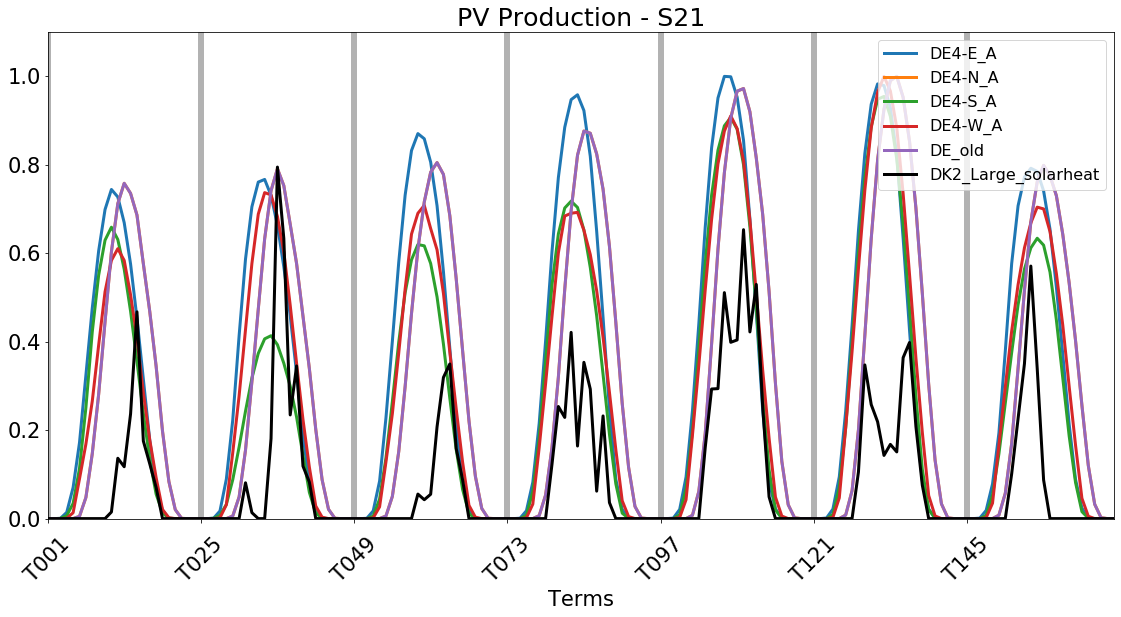

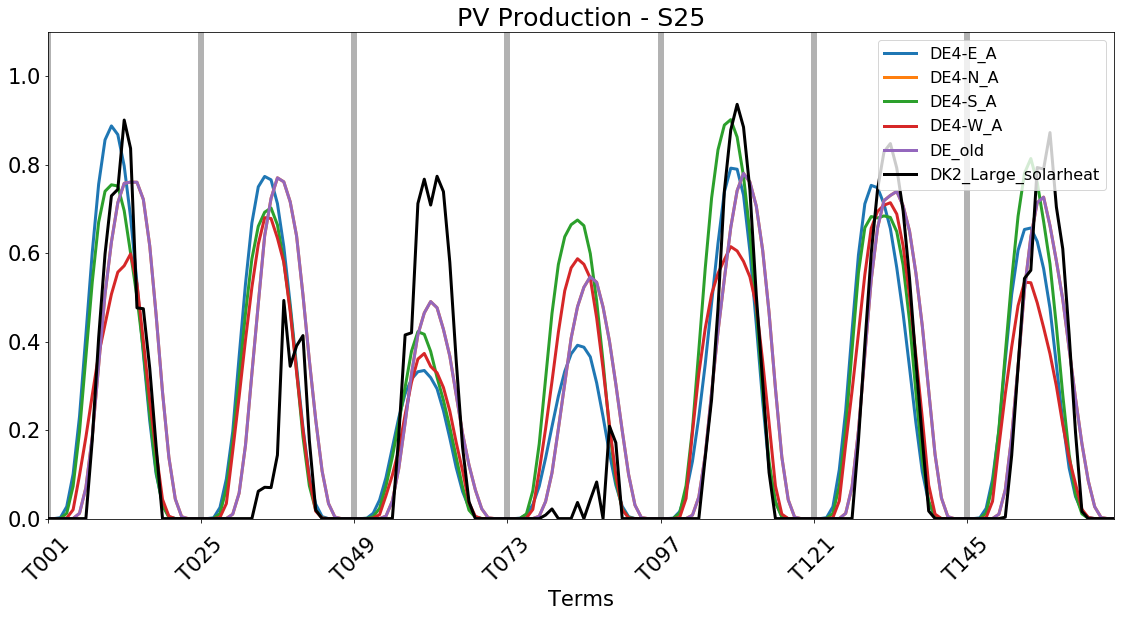

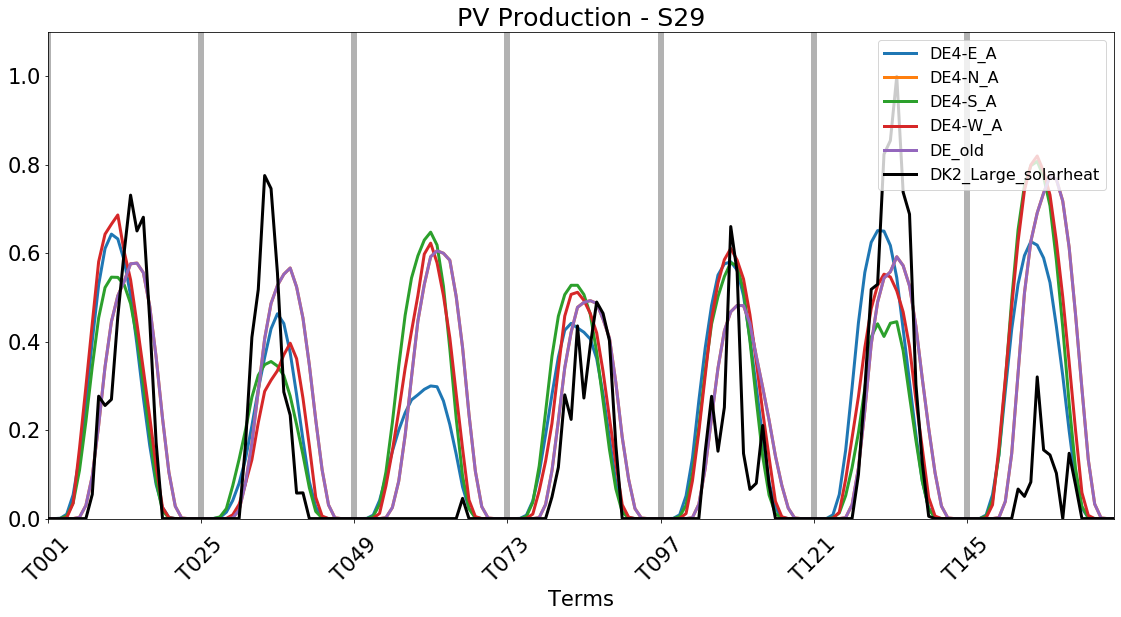

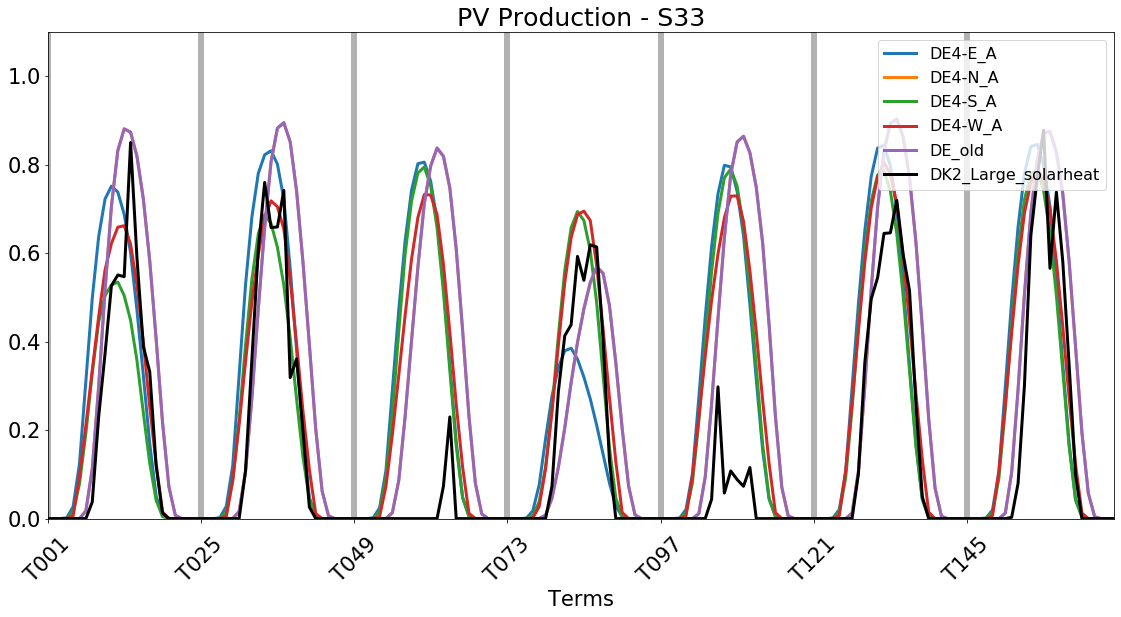

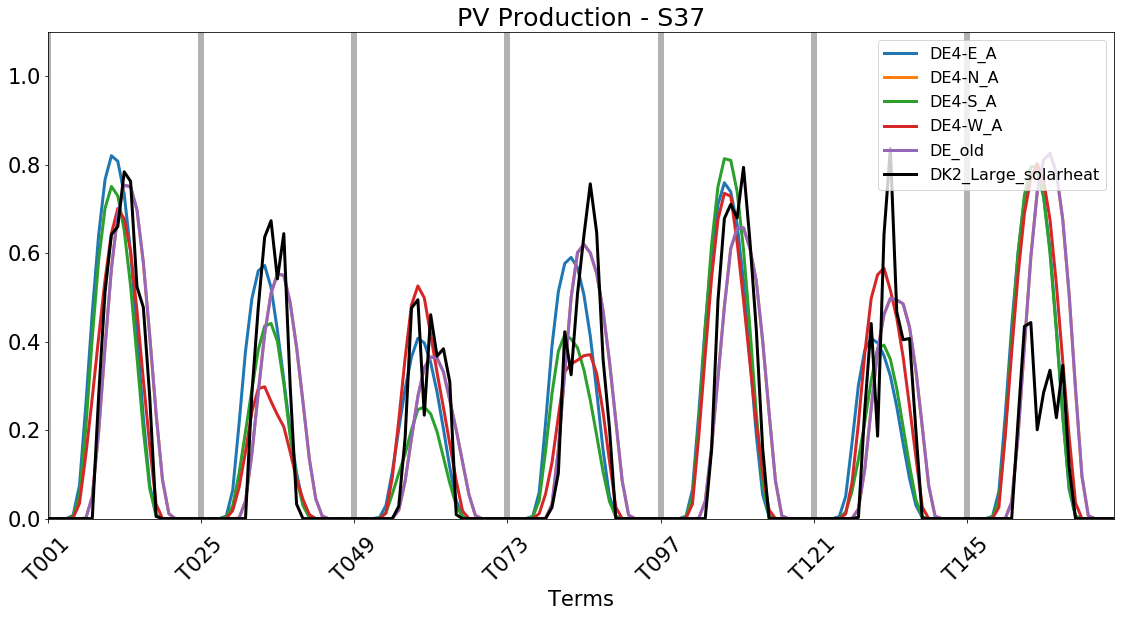

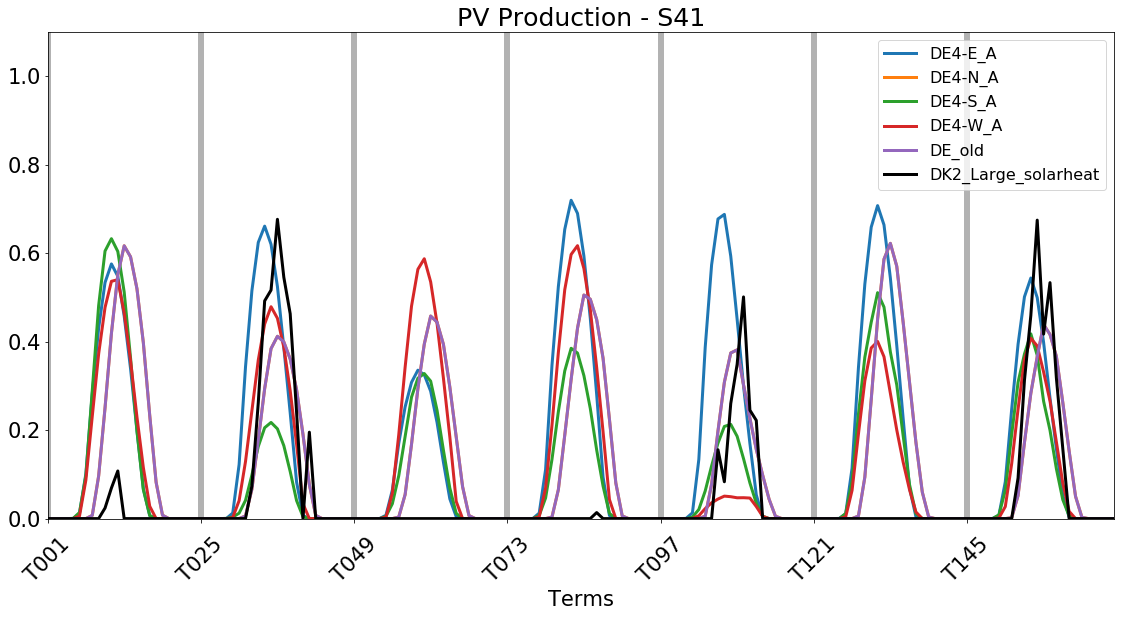

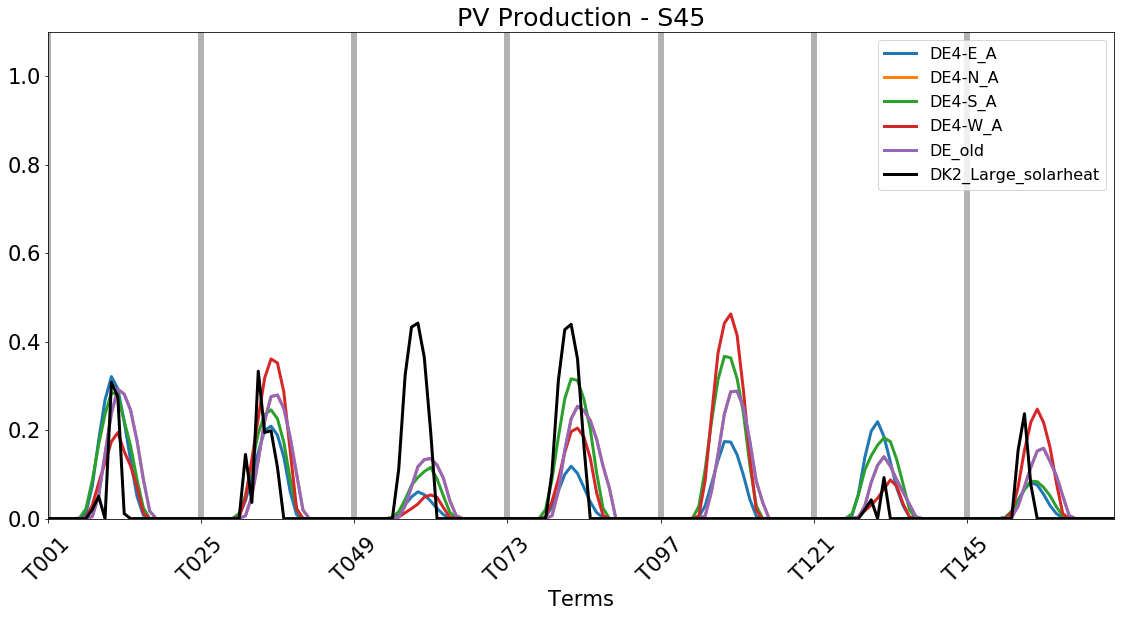

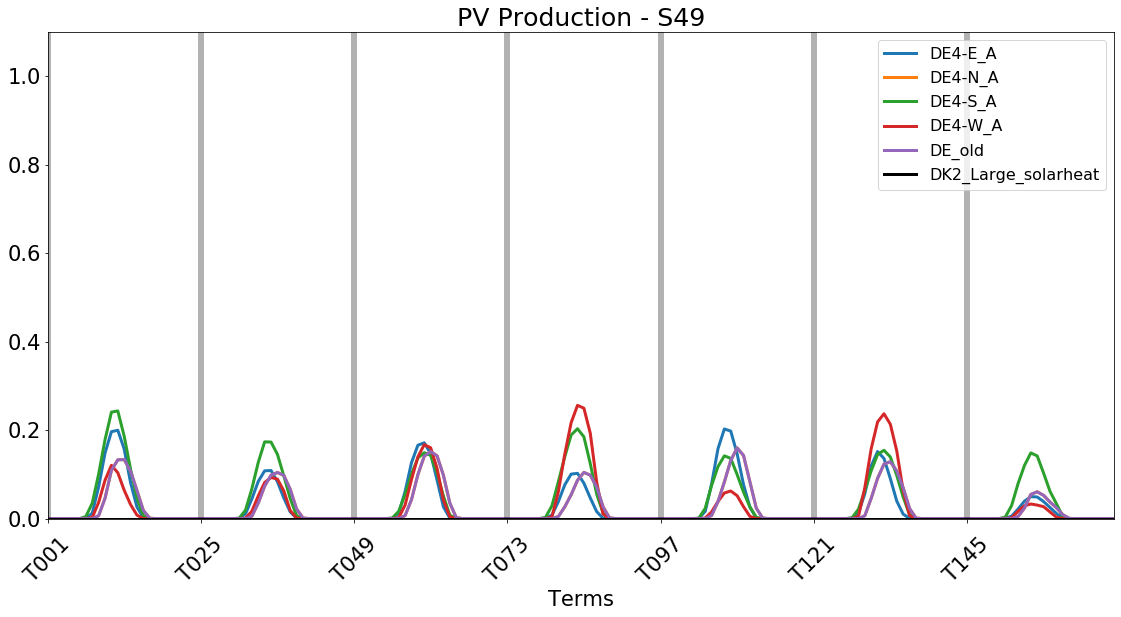

In [123]:
for i in s:
    x = spp_plot[spp_plot.season.isin([i])][spp_plot.columns[spp_plot.columns.str.contains(ccc[0])]].plot(figsize=(16,9), lw=lw)
    spp_old_plot[spp_old_plot.season.isin([i])]['DE'].plot(x=x, figsize=(16,9), lw=lw, label='DE_old')
    shp_plot[shp_plot.season.isin([i])]['DK2_Large'].plot(x=x, figsize=(16,9), lw=lw, c='black', label='DK2_Large_solarheat')
    plt.ylim([0, y_limit])
    plt.legend(loc=1)
    plt.title('PV Production' + ' - ' + i)
    plt.xlabel('Terms')
    plt.xticks(t_marker, t_selected, rotation=45)
    for x_pos in t_marker:
        plt.axvline(x=x_pos, c='black', lw=6, alpha=0.3)
    plt.tight_layout()
    plt.savefig('output/figs/pv_production/spp_' + i + '.png', compression=None)
    plt.show()
    plt.close()
plt.close()

#### Variation of Wind Generation

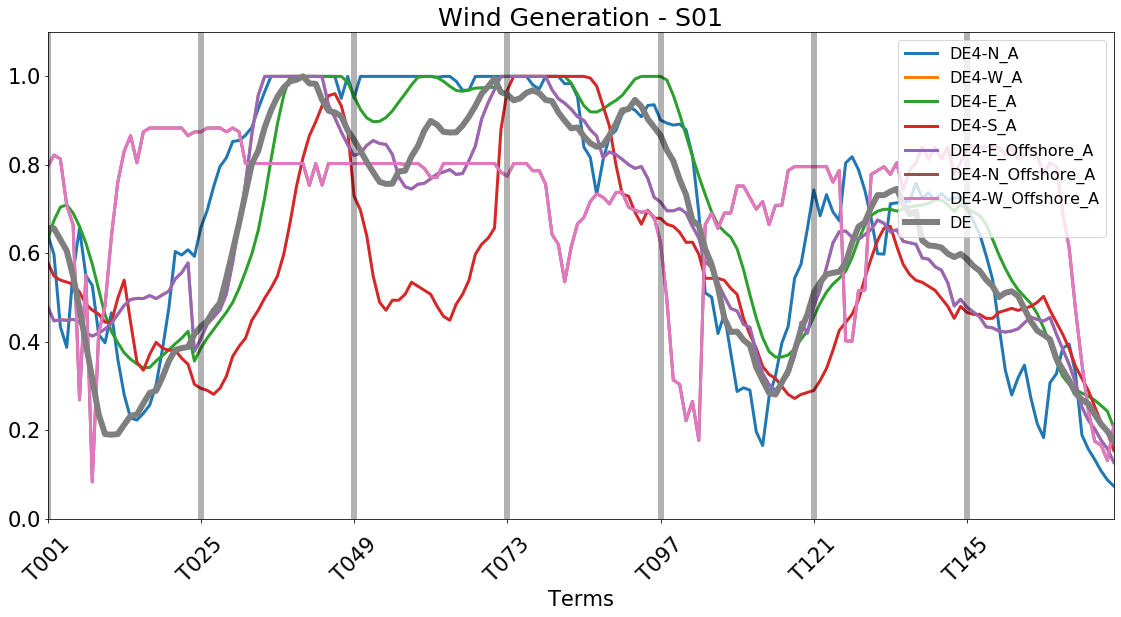

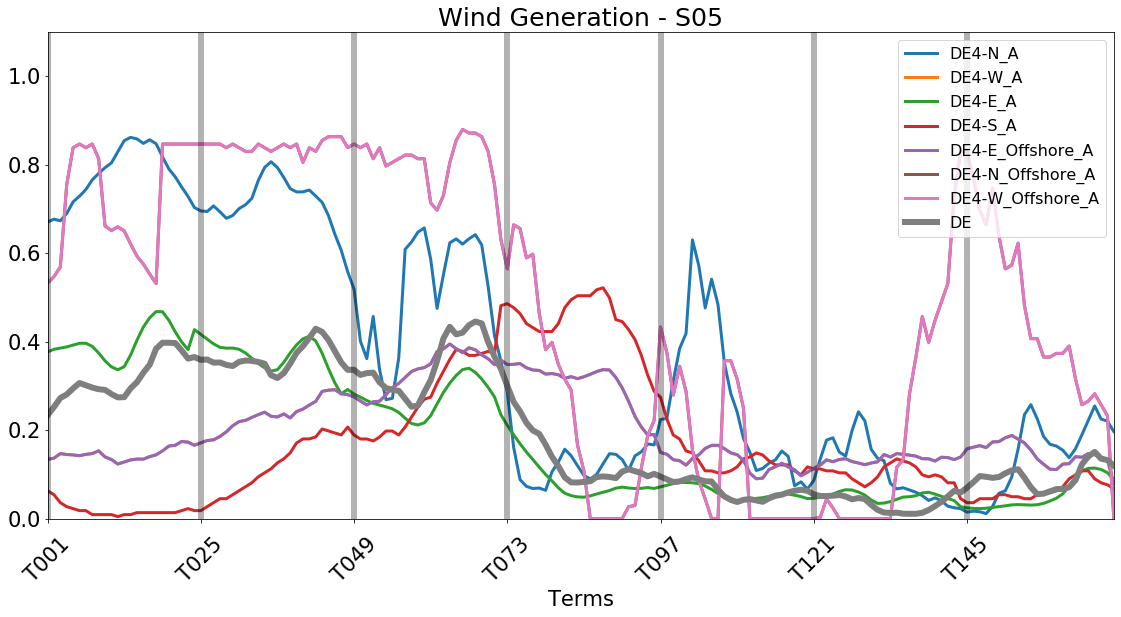

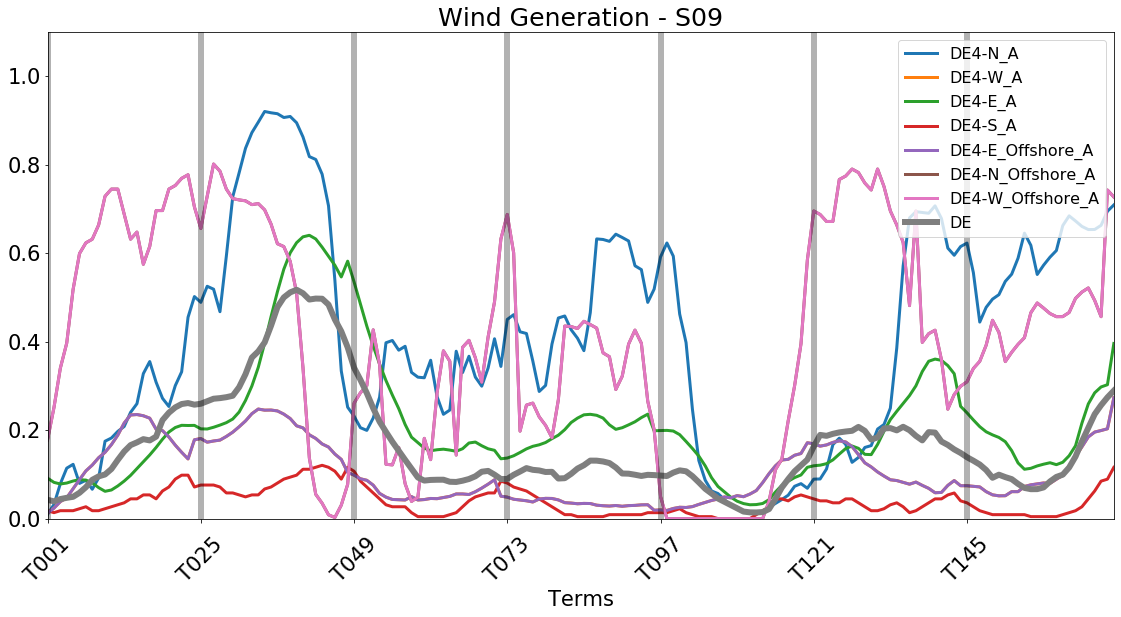

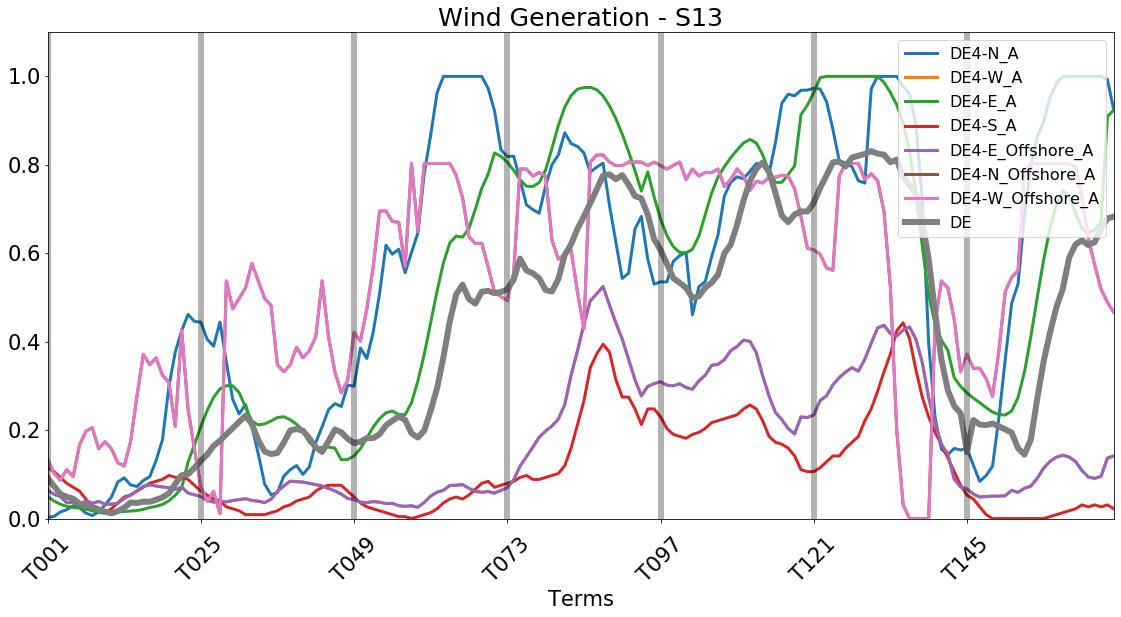

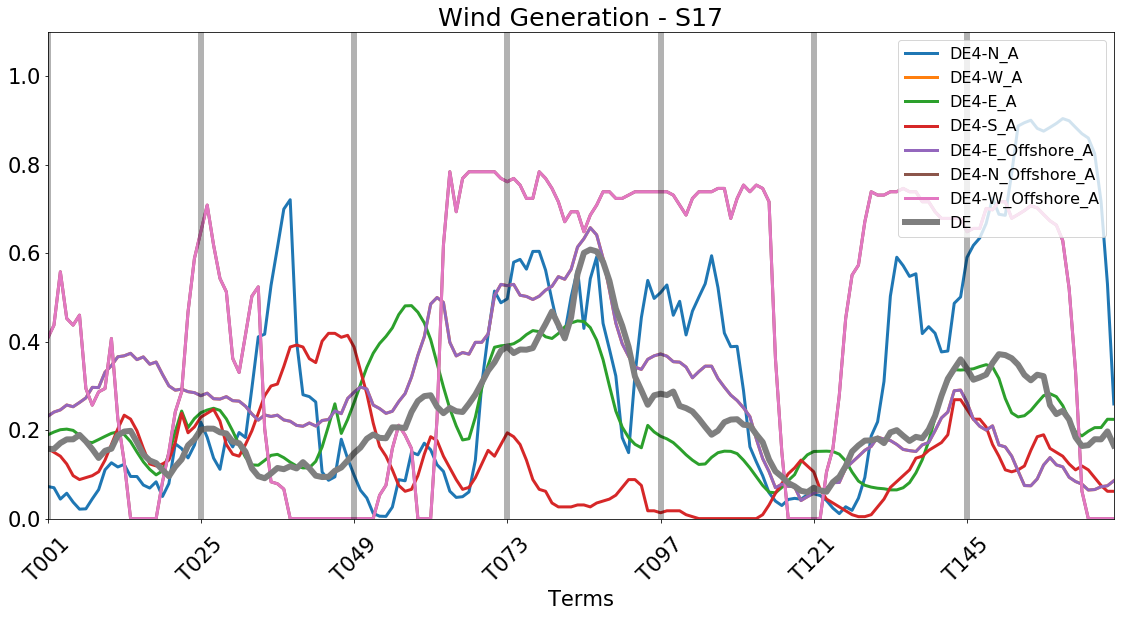

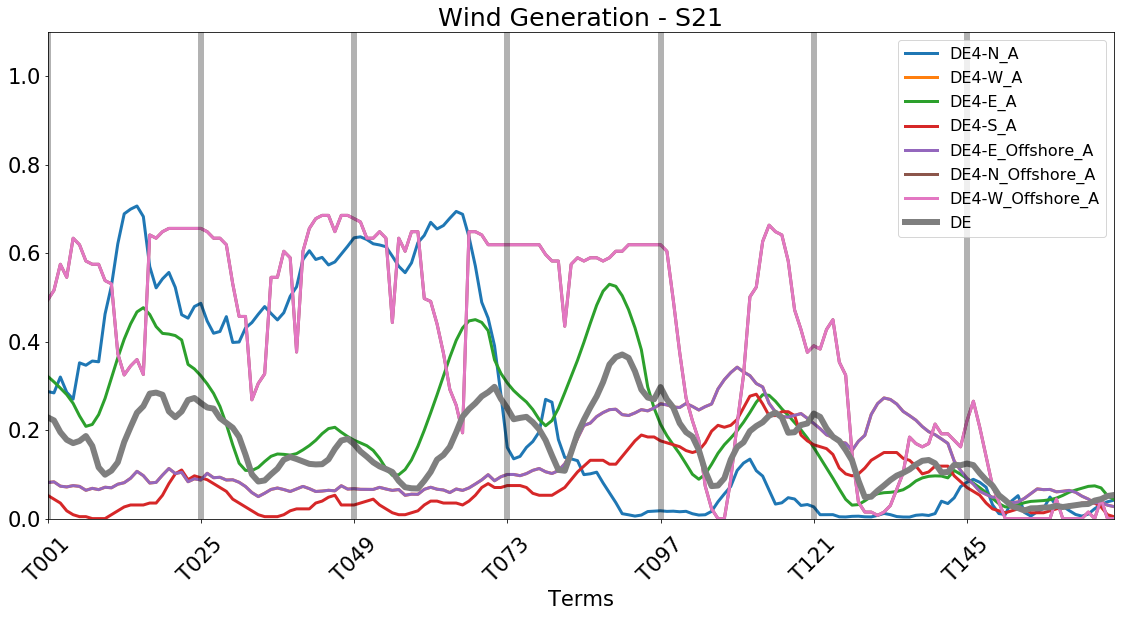

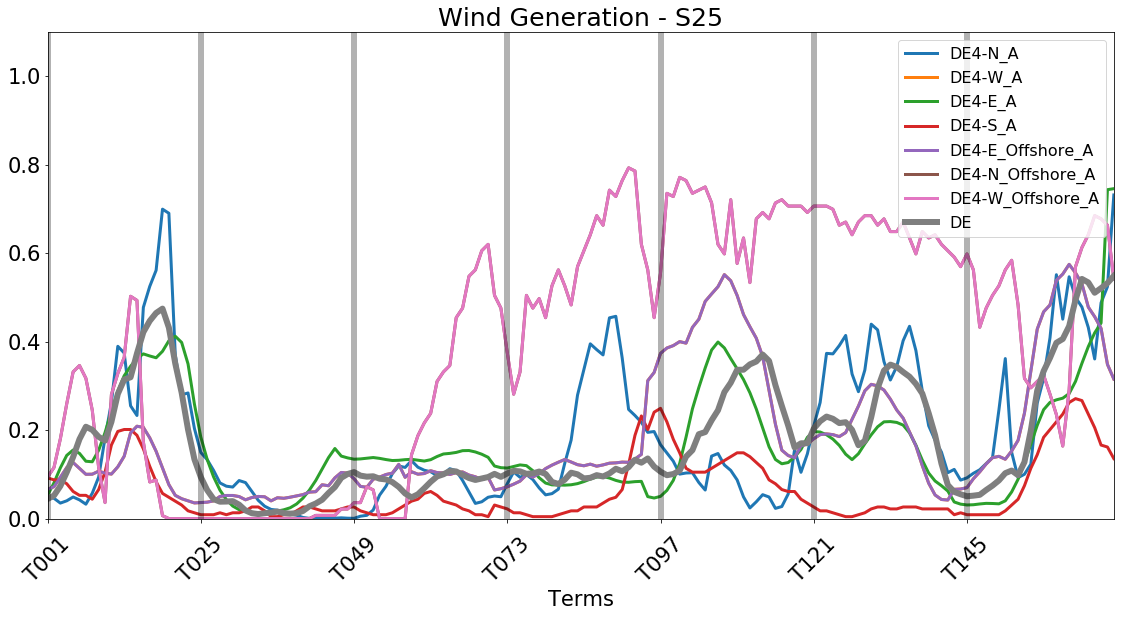

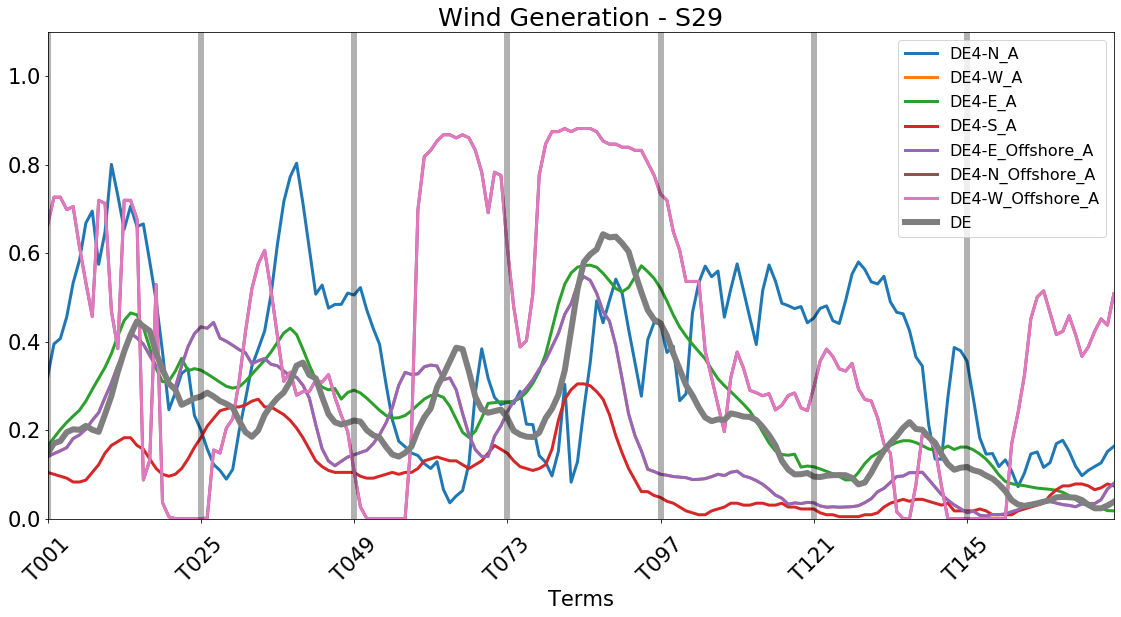

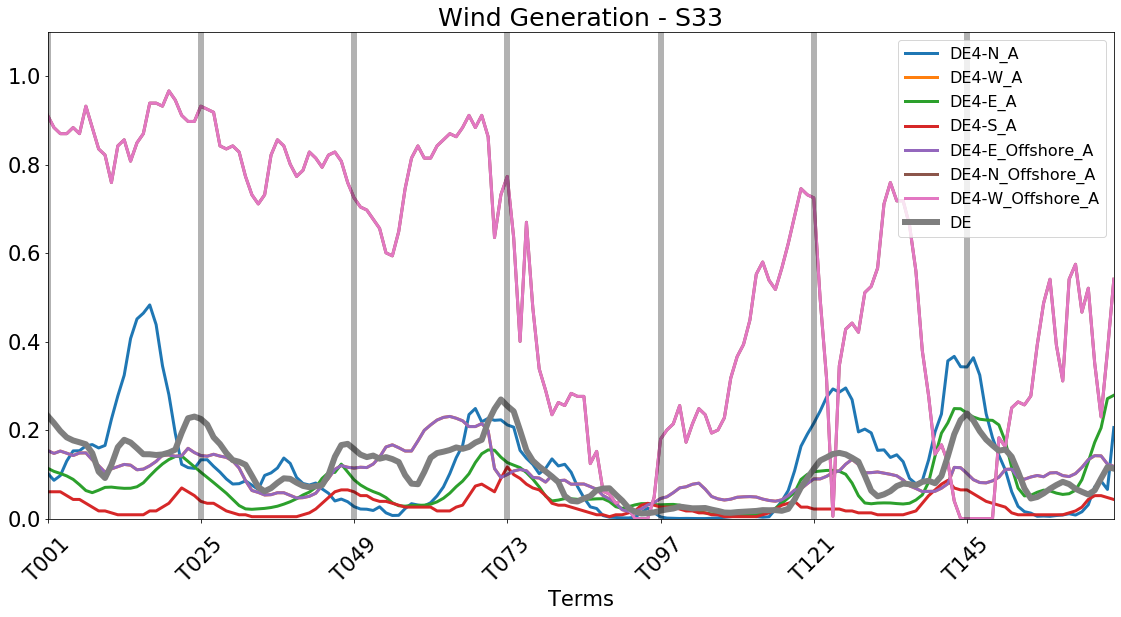

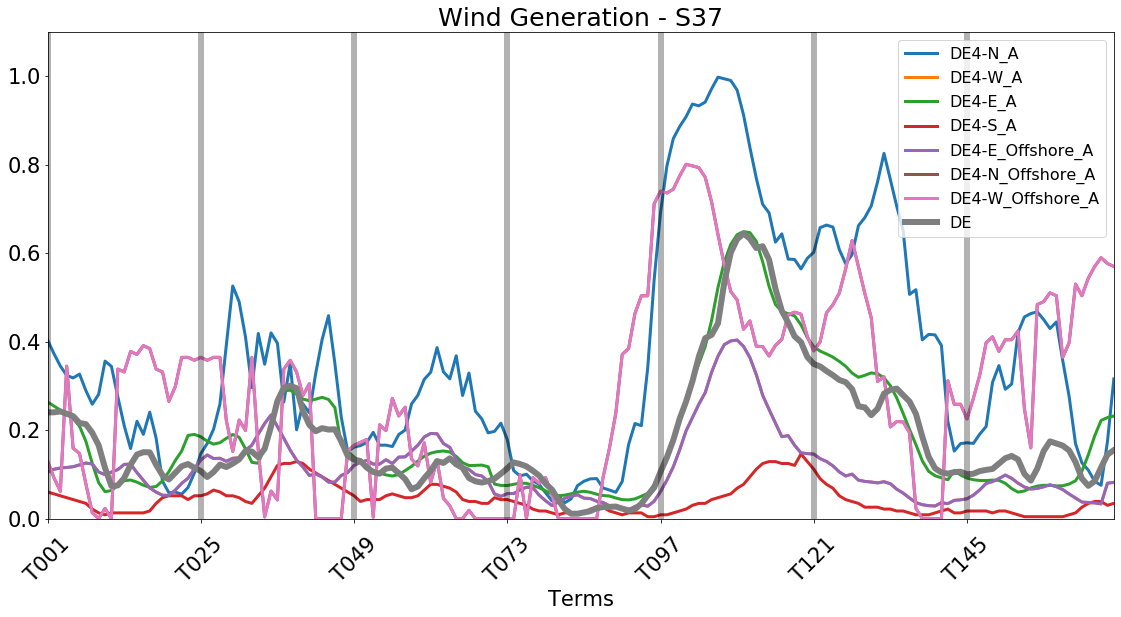

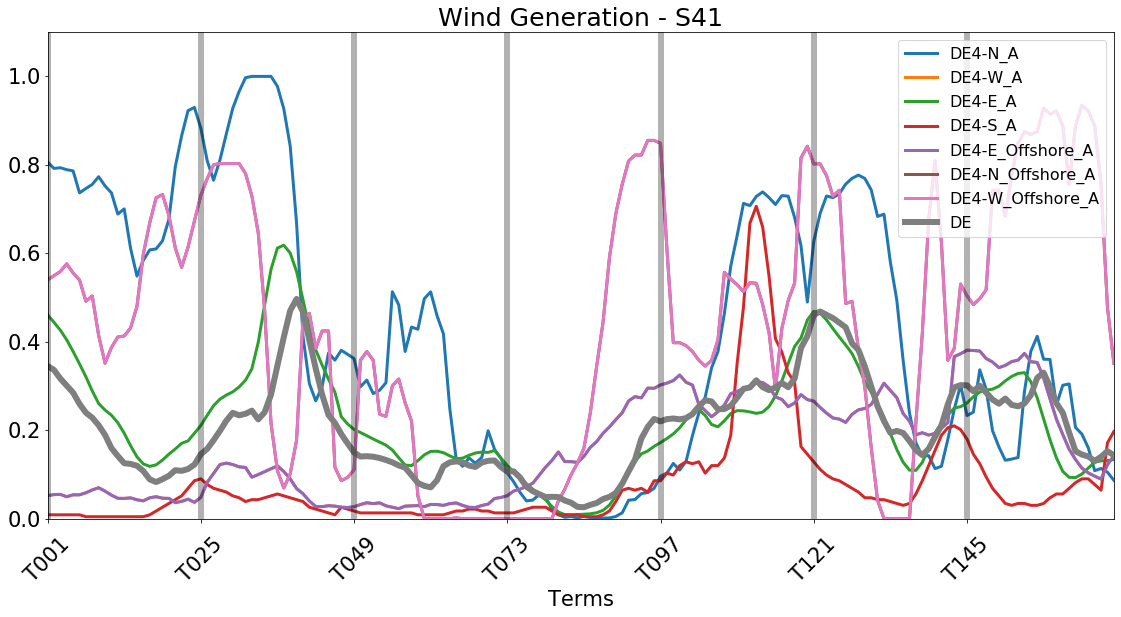

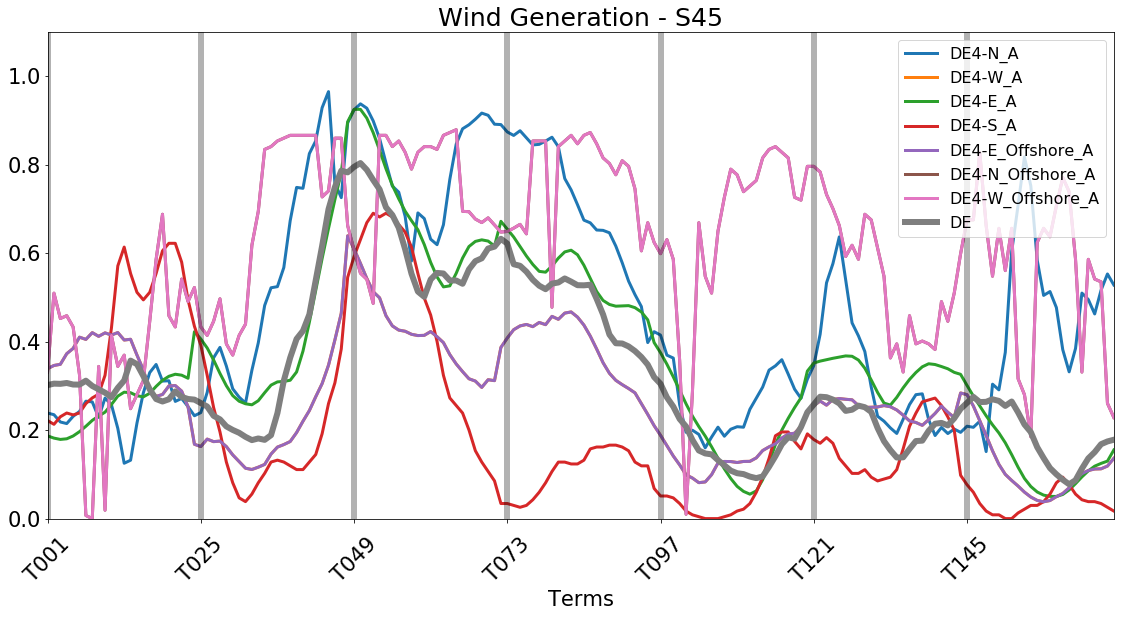

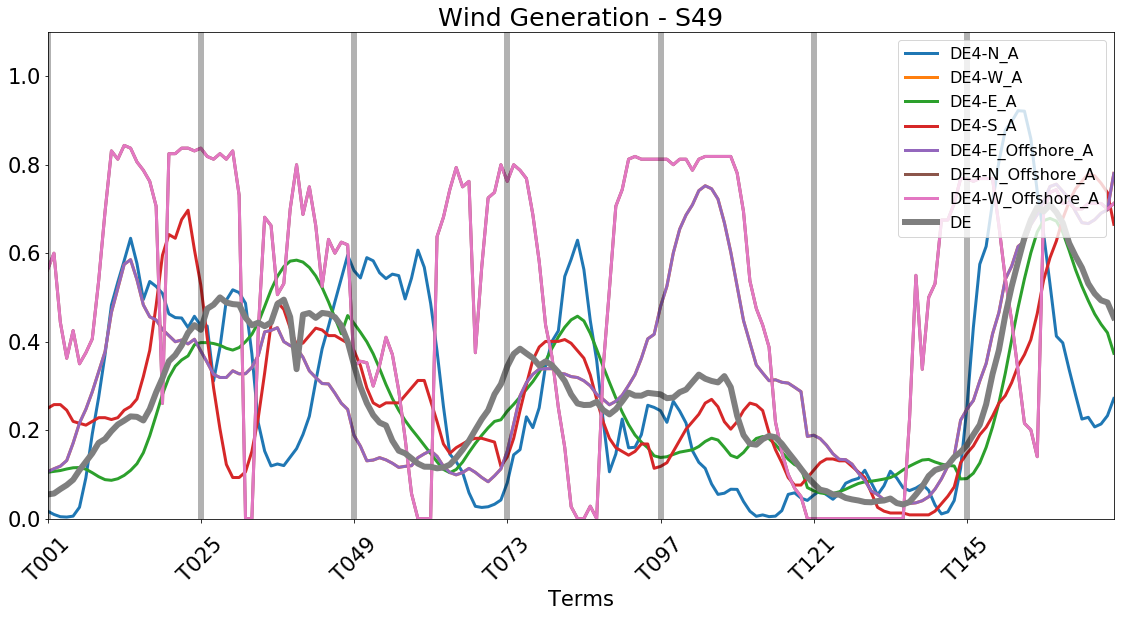

In [124]:
for i in s:
    x = vwg_plot[vwg_plot.season.isin([i])][vwg_plot.columns[vwg_plot.columns.str.contains(ccc[0])]].plot(figsize=(16,9), lw=lw)
    vwg_old_plot[vwg_old_plot.season.isin([i])]['DE'].plot(x=x, figsize=(16,9), lw=lw*2)
    plt.ylim([0, y_limit])
    plt.legend(loc=1)
    plt.title('Wind Generation' + ' - ' + i)
    plt.xlabel('Terms')
    plt.xticks(t_marker, t_selected, rotation=45)
    for x_pos in t_marker:
        plt.axvline(x=x_pos, c='black', lw=6, alpha=0.3)
    plt.tight_layout()
    plt.savefig('output/figs/wind_generation/vwg_' + i + '.png', compression=None)
    plt.show()
    plt.close()
plt.close()